In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from glob import glob
import sys
import torch
from tqdm import tqdm
import pdb

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dca_research.cov_util import calc_mmse_from_cross_cov_mats
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [4]:
sys.path.append('/home/akumar/nse/neural_control')

In [5]:
from loaders import load_sabes
from utils import apply_df_filters

### LQG spectrum

In [6]:
# Return the full LQG spectrum rather than just the trace
def get_LQG_spectrum(ccm_fwd, ccm_rev, V):
    project_mmse=False
    mmse_fwd = calc_mmse_from_cross_cov_mats(ccm_fwd, V, project_mmse=project_mmse)    

    # Key change 06/28/22: In the reverse time direction, the readout is taken to be y = C Pi x_a = C x. 
    # This is implemented here by scaling Vlag by ccm_fwd[0]
    Vrev = torch.matmul(ccm_fwd[0], V)
    mmse_rev = calc_mmse_from_cross_cov_mats(ccm_rev, Vrev, project_mmse=project_mmse)

    return np.linalg.eigvals(mmse_fwd @ mmse_rev)

In [3]:
# Across projection dimensions, calculate the LQG spectrum, rather than just taking the trace.
# Fit a state space model to the dynamics, caclculte the LQG controller parameters, and then show evolution of various LQG related loss
# functions as one truncates the filter order

In [7]:
fls_ = glob('/mnt/Secondary/data/sabes/*.mat')

good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

# Filter by the loco files we want to use
fls = []
for f in fls_:
    if 'indy' in f:
        fls.append(f)
    elif f.split('/')[-1] in good_loco_files:
        fls.append(f)

In [72]:
spec_full = []
for fl in tqdm(fls):
    dat = load_sabes(fl)

    X = np.squeeze(dat['spike_rates'])

    lqgmodel = LQGCA(T=4)
    lqgmodel.estimate_data_statistics(X)

    s = get_LQG_spectrum(lqgmodel.cross_covs.float(), lqgmodel.cross_covs_rev.float(), torch.eye(X.shape[1]).float())
    spec_full.append(s)

100%|██████████| 35/35 [04:11<00:00,  7.18s/it]


In [73]:
[np.sum(s)/s.size for s in spec_full]

[0.8527977522029433,
 0.9048511135962701,
 0.9273077427655801,
 0.8408111981897546,
 0.9337591270490878,
 0.9509454314241704,
 0.8184287227801422,
 0.8138201720732495,
 0.8316819096954775,
 0.8202723627505095,
 0.8201636642706199,
 0.8367185119196032,
 0.8415643176893248,
 0.8630679281134355,
 0.8520217664314039,
 0.8459631558122306,
 0.8467134915865384,
 0.8376592889532343,
 0.8455633119095204,
 0.8477876036317198,
 0.8861344211785368,
 0.8305467709090358,
 0.862694573780847,
 0.8839998747173109,
 0.8677368779336253,
 0.8594887222068898,
 0.8789774576822916,
 0.887050683947577,
 0.938709615803451,
 0.953268624685861,
 0.9398571224663201,
 0.9450412901107874,
 0.940306689857778,
 0.9120771789550781,
 0.9495771789550781]

In [29]:
lqgspec = [np.sort(s)[::-1][0:90] for s in spec]

In [30]:
lqgspec = np.array(lqgspec)

In [31]:
lqgspec.shape

(35, 90)

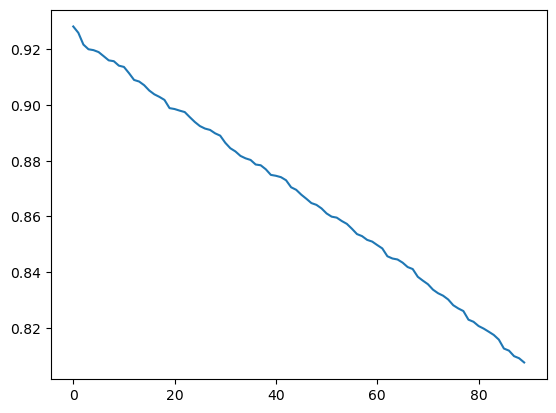

In [43]:
plt.plot(lqgspec[7, :])

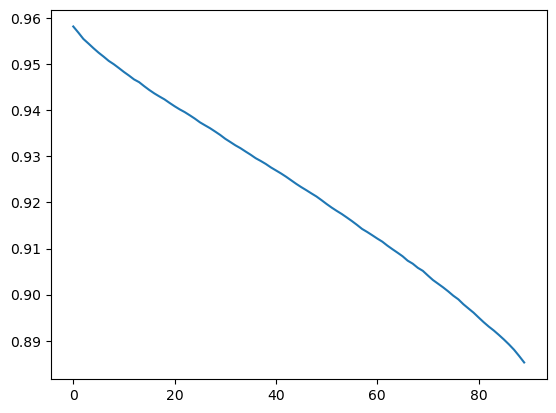

In [32]:
plt.plot(np.mean(lqgspec, axis=0))

In [ ]:
# This is a bit surprising. What does the spectrum look like at d = 30?

In [46]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    indy_df = pickle.load(f)
indy_df = pd.DataFrame(indy_df)

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        
sabes_df = pd.concat([loco_df, indy_df])

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [50]:
spec = []
for fl in tqdm(fls):
    dat = load_sabes(fl)

    X = np.squeeze(dat['spike_rates'])

    lqgmodel = LQGCA(T=4)
    lqgmodel.estimate_data_statistics(X)

    df = apply_df_filters(sabes_df, data_file=fl.split('/')[-1], fold_idx=0, dim=30, dimreduc_method='LQGCA')
    assert(df.shape[0] == 1)

    V = torch.tensor(df.iloc[0]['coef']).float()

    s = get_LQG_spectrum(lqgmodel.cross_covs.float(), lqgmodel.cross_covs_rev.float(), V)
    print(np.trace(s))
    spec.append(s)


100%|██████████| 35/35 [04:20<00:00,  7.45s/it]


In [61]:
drspec = np.array([np.sort(s)[::-1][0:90] for s in spec])

In [71]:
[np.sum(s)/s.size for s in spec]

[0.9302895715994428,
 0.9498072798534106,
 0.9583637632172683,
 0.93353629912306,
 0.9566147644395773,
 0.9685624899323454,
 0.9215596896498951,
 0.9208069421294937,
 0.927000556193607,
 0.9229795483575352,
 0.9142729337098169,
 0.9274315800227172,
 0.9283711788428091,
 0.9398074902986225,
 0.9306289210464015,
 0.9327647242052802,
 0.9281823378342848,
 0.9279202547940341,
 0.9250709474548813,
 0.9272517491053868,
 0.9409841493118641,
 0.9190071165099625,
 0.9311123802548363,
 0.9401775828579015,
 0.9293467613958544,
 0.9319731118022532,
 0.9443334462691326,
 0.9419615372367527,
 0.9675638761451776,
 0.9733711722847465,
 0.9730437271238312,
 0.9746777378233139,
 0.9746793462426623,
 0.9702131652832031,
 0.9802337646484375]

In [ ]:
# This is suprisingly high dimensional

In [ ]:
# What about down to d=10?

### Scores

In [8]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    indy_df = pickle.load(f)
indy_df = pd.DataFrame(indy_df)

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        
sabes_df = pd.concat([loco_df, indy_df])

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [10]:
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [18]:
# What is the fraction of the asymptotic LQR cost attained?
dimvals = np.unique(sabes_df['dim'].values)
data_files = np.unique(sabes_df['data_file'].values)

fcca_scores = np.zeros((dimvals.size, data_files.size, 5))
pca_scores = np.zeros((dimvals.size, data_files.size, 5))

for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])
    for f, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5).split(X)):
        xtrain = X[train_idxs]
        pcamodel = PCA().fit(xtrain)

        for j, d in enumerate(dimvals):
            df = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', fold_idx=f, dim=d)
            assert(df.shape[0] == 1)
            lqgmodel = LQGCA(T=3)
            lqgscore = lqgmodel.score(X=xtrain, coef=df.iloc[0]['coef'])
            fcca_scores[j, i, f] = lqgscore            
            pca_scores[j, i, f] = np.sum(pcamodel.explained_variance_ratio_[0:d])

In [ ]:
# Normalize by the ambient scores
fcca_ambient = np.zeros((data_files.size, 5))
for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])
    for f, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5).split(X)):
        xtrain = X[train_idxs]

        lqgmodel = LQGCA(T=3)
        lqgscore = lqgmodel.score(X=xtrain, coef=df.iloc[0]['coef'])

        

In [ ]:
# Plot

### Sequential subspace angles